<a href="https://colab.research.google.com/github/ciepielajan/SDA_SMOG_Wawelski/blob/main/Beata/smog3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
link = "https://drive.google.com/file/d/1gwPP5TlL0zYHDkSjowfnR0DU8rsj1bTd/view?usp=sharing"
link_id = link.split("/")[-2]
!gdown --id $link_id
!unzip smog1.zip

Downloading...
From: https://drive.google.com/uc?id=1gwPP5TlL0zYHDkSjowfnR0DU8rsj1bTd
To: /content/smog1.zip
2.39MB [00:00, 76.3MB/s]
Archive:  smog1.zip
  inflating: april-2017.csv          
  inflating: august-2017.csv         
  inflating: december-2017.csv       
  inflating: february-2017.csv       
  inflating: january-2017.csv        
  inflating: july-2017.csv           
  inflating: june-2017.csv           
  inflating: march-2017.csv          
  inflating: may-2017.csv            
  inflating: november-2017.csv       
  inflating: october-2017.csv        
  inflating: sensor_locations.csv    
  inflating: september-2017.csv      


In [2]:
import numpy as np
import pandas as pd
import math
import sklearn
import keras
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import KMeans

In [3]:
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

from keras.utils import plot_model


In [7]:
df_loc = pd.read_csv('sensor_locations.csv')

In [10]:
df_loc.head(1)

,id,latitude,longitude
0,3,50.057748,19.961375


In [11]:
df_loc.set_index('id', drop=True, inplace=True)

In [13]:
df_loc.head(1)

,latitude,longitude
id,,
3,50.057748,19.961375


In [14]:
clusters = KMeans(n_clusters=9).fit(df_loc)

In [17]:
clusters

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [18]:
centroids = clusters.cluster_centers_

In [19]:
centroids

array([[50.05587157, 19.912466  ],
       [50.0262695 , 19.99215317],
       [50.03464967, 19.84688133],
       [50.08219571, 20.021132  ],
       [50.01809517, 19.91288267],
       [50.06460986, 19.95469164],
       [50.08062917, 19.880885  ],
       [50.048699  , 20.101569  ],
       [50.09496183, 19.90988883]])

Text(0, 0.5, 'longitude')

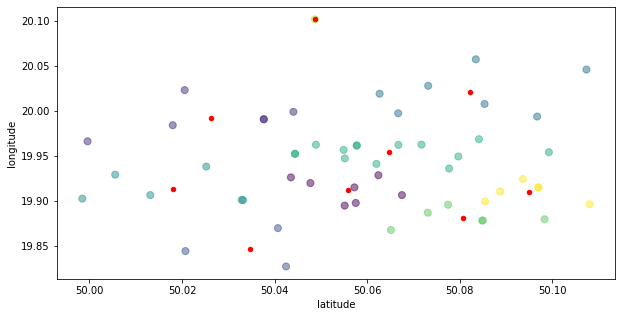

In [22]:
plt.figure(figsize=(10,5))
plt.scatter(df_loc['latitude'], df_loc['longitude'], c= clusters.labels_.astype(float), cmap='viridis', s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=20)
plt.xlabel('latitude')
plt.ylabel('longitude')

In [33]:
try:
    df_loc.reset_index(inplace=True)
except ValueError:
    pass
try:
    df_loc.drop(columns=['level_0', 'index'], inplace=True)
except KeyError:
    pass
arr = df_loc[['latitude', 'longitude']].values
df_loc['nearest_dist'] = 0
df_loc['nearest'] = df_loc.index.values
def fsi_numpy(item_id):
    ind = df_loc[df_loc.id == item_id].index.values[0]
    tmp_arr = arr - arr[ind]
    tmp_ser = np.sum( np.square( tmp_arr ), axis=1 )
    return tmp_ser
for item_id in df_loc.id.values:
    df_loc['dist'] = fsi_numpy(item_id)
    nearest5 = df_loc.copy().sort_values('dist').head(5)
    try:
        nearest5 = nearest5.drop(columns='level_0')
    except KeyError:
        pass
    nearest5 = nearest5.reset_index()
    df_loc.loc[df_loc[df_loc['id'] == item_id].index.values[0], 'nearest_dist'] = nearest5.dist.values[2]
    df_loc.loc[df_loc[df_loc['id'] == item_id].index.values[0], 'nearest'] = nearest5.id.values[2]
df_loc.sort_values('nearest_dist').head(5)

,id,latitude,longitude,nearest_dist,nearest,dist
1,140,50.057747,19.961374,0.000032,201,0.007692
0,3,50.057748,19.961375,0.000032,201,0.007693
26,201,50.054907,19.956501,0.000032,3,0.007066
3,147,50.048924,19.962262,0.000079,140,0.008399
25,196,50.066747,19.962083,0.000081,3,0.007402


In [34]:
styczen = pd.read_csv("january-2017.csv")


In [35]:
styczen.head(2)

,UTC time,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,140_pm1,140_pm25,140_pm10,142_temperature,142_humidity,142_pressure,142_pm1,142_pm25,142_pm10,147_temperature,147_humidity,147_pressure,147_pm1,147_pm25,147_pm10,169_temperature,169_humidity,169_pressure,169_pm1,169_pm25,169_pm10,170_temperature,170_humidity,170_pressure,170_pm1,170_pm25,170_pm10,171_temperature,171_humidity,171_pressure,...,228_pressure,228_pm1,228_pm25,228_pm10,263_temperature,263_humidity,263_pressure,263_pm1,263_pm25,263_pm10,622_temperature,622_humidity,622_pressure,622_pm1,622_pm25,622_pm10,713_temperature,713_humidity,713_pressure,713_pm1,713_pm25,713_pm10,808_temperature,808_humidity,808_pressure,808_pm1,808_pm25,808_pm10,857_temperature,857_humidity,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
0,2017-01-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,68.0,102279.0,115.0,127.0,196.0,-3.0,57.0,102505.0,196.0,222.0,346.0,0.0,49.0,102689.0,124.0,145.0,229.0,2,25,102379,148,176,277,1.0,27.0,102437.0,...,102253,184,218,322,0.0,54.0,101672.0,137.0,153.0,235.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01T01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,68.0,102228.0,105.0,116.0,180.0,-3.0,56.0,102454.0,187.0,211.0,330.0,0.0,49.0,102635.0,124.0,145.0,230.0,1,25,102325,131,156,247,0.0,27.0,102387.0,...,102201,146,169,250,0.0,52.0,101623.0,119.0,132.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
import os

In [ ]:
os.getcwd()

In [38]:
os.listdir()

['.config',
 'september-2017.csv',
 'february-2017.csv',
 'june-2017.csv',
 'october-2017.csv',
 'may-2017.csv',
 'march-2017.csv',
 'november-2017.csv',
 'april-2017.csv',
 'december-2017.csv',
 'smog1.zip',
 'july-2017.csv',
 'august-2017.csv',
 'sensor_locations.csv',
 'january-2017.csv',
 'sample_data']

In [39]:
files = []
for r, d, f in os.walk("/content"):
    for file in f:
        if '2017' in file:
            files.append(os.path.join(r, file))


In [45]:
df_jan = pd.read_csv(files[11])

In [46]:
df_jan.head(2)

,UTC time,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,140_pm1,140_pm25,140_pm10,142_temperature,142_humidity,142_pressure,142_pm1,142_pm25,142_pm10,147_temperature,147_humidity,147_pressure,147_pm1,147_pm25,147_pm10,169_temperature,169_humidity,169_pressure,169_pm1,169_pm25,169_pm10,170_temperature,170_humidity,170_pressure,170_pm1,170_pm25,170_pm10,171_temperature,171_humidity,171_pressure,...,228_pressure,228_pm1,228_pm25,228_pm10,263_temperature,263_humidity,263_pressure,263_pm1,263_pm25,263_pm10,622_temperature,622_humidity,622_pressure,622_pm1,622_pm25,622_pm10,713_temperature,713_humidity,713_pressure,713_pm1,713_pm25,713_pm10,808_temperature,808_humidity,808_pressure,808_pm1,808_pm25,808_pm10,857_temperature,857_humidity,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
0,2017-01-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,68.0,102279.0,115.0,127.0,196.0,-3.0,57.0,102505.0,196.0,222.0,346.0,0.0,49.0,102689.0,124.0,145.0,229.0,2,25,102379,148,176,277,1.0,27.0,102437.0,...,102253,184,218,322,0.0,54.0,101672.0,137.0,153.0,235.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01T01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,68.0,102228.0,105.0,116.0,180.0,-3.0,56.0,102454.0,187.0,211.0,330.0,0.0,49.0,102635.0,124.0,145.0,230.0,1,25,102325,131,156,247,0.0,27.0,102387.0,...,102201,146,169,250,0.0,52.0,101623.0,119.0,132.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
styczen

,UTC time,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,140_pm1,140_pm25,140_pm10,142_temperature,142_humidity,142_pressure,142_pm1,142_pm25,142_pm10,147_temperature,147_humidity,147_pressure,147_pm1,147_pm25,147_pm10,169_temperature,169_humidity,169_pressure,169_pm1,169_pm25,169_pm10,170_temperature,170_humidity,170_pressure,170_pm1,170_pm25,170_pm10,171_temperature,171_humidity,171_pressure,...,228_pressure,228_pm1,228_pm25,228_pm10,263_temperature,263_humidity,263_pressure,263_pm1,263_pm25,263_pm10,622_temperature,622_humidity,622_pressure,622_pm1,622_pm25,622_pm10,713_temperature,713_humidity,713_pressure,713_pm1,713_pm25,713_pm10,808_temperature,808_humidity,808_pressure,808_pm1,808_pm25,808_pm10,857_temperature,857_humidity,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
0,2017-01-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,68.0,102279.0,115.0,127.0,196.0,-3.0,57.0,102505.0,196.0,222.0,346.0,0.0,49.0,102689.0,124.0,145.0,229.0,2,25,102379,148,176,277,1.0,27.0,102437.0,...,102253,184,218,322,0.0,54.0,101672.0,137.0,153.0,235.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01T01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,68.0,102228.0,105.0,116.0,180.0,-3.0,56.0,102454.0,187.0,211.0,330.0,0.0,49.0,102635.0,124.0,145.0,230.0,1,25,102325,131,156,247,0.0,27.0,102387.0,...,102201,146,169,250,0.0,52.0,101623.0,119.0,132.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01T02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,66.0,102149.0,110.0,121.0,189.0,-4.0,55.0,102375.0,187.0,212.0,333.0,0.0,49.0,102558.0,108.0,125.0,201.0,1,24,102244,108,127,203,1.0,27.0,102310.0,...,102119,138,160,237,0.0,49.0,101536.0,97.0,105.0,162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01T03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,66.0,102097.0,107.0,118.0,184.0,-4.0,52.0,102322.0,167.0,188.0,296.0,0.0,48.0,102507.0,102.0,117.0,188.0,1,24,102192,104,123,197,0.0,27.0,102260.0,...,102064,137,158,234,0.0,47.0,101483.0,86.0,92.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01T04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,65.0,102047.0,112.0,123.0,193.0,-3.0,51.0,102277.0,164.0,184.0,290.0,0.0,49.0,102463.0,96.0,110.0,179.0,1,24,102144,98,115,186,0.0,27.0,102212.0,...,102024,148,173,256,0.0,47.0,101441.0,84.0,90.0,140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2017-01-31T19:00:00,NaN,NaN,101783.0,82.0,84.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,74.0,101629.0,108.0,114.0,160.0,-2.0,73.0,101873.0,95.0,97.0,137.0,0.0,76.0,102138.0,76.0,82.0,119.0,0,68,101859,85,95,137,0.0,68.0,101921.0,...,101697,82,88,127,0.0,77.0,101119.0,86.0,89.0,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
740,2017-01-31T20:00:00,NaN,NaN,101813.0,95.0,99.0,140.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,77.0,101656.0,127.0,136.0,194.0,-2.0,76.0,101902.0,139.0,146.0,204.0,-1.0,78.0,102170.0,69.0,74.0,107.0,0,71,101888,82,92,133,-1.0,71.0,101952.0,...,101727,86,92,134,-1.0,80.0,101151.0,81.0,83.0,123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [48]:
df_jan

,UTC time,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,140_pm1,140_pm25,140_pm10,142_temperature,142_humidity,142_pressure,142_pm1,142_pm25,142_pm10,147_temperature,147_humidity,147_pressure,147_pm1,147_pm25,147_pm10,169_temperature,169_humidity,169_pressure,169_pm1,169_pm25,169_pm10,170_temperature,170_humidity,170_pressure,170_pm1,170_pm25,170_pm10,171_temperature,171_humidity,171_pressure,...,228_pressure,228_pm1,228_pm25,228_pm10,263_temperature,263_humidity,263_pressure,263_pm1,263_pm25,263_pm10,622_temperature,622_humidity,622_pressure,622_pm1,622_pm25,622_pm10,713_temperature,713_humidity,713_pressure,713_pm1,713_pm25,713_pm10,808_temperature,808_humidity,808_pressure,808_pm1,808_pm25,808_pm10,857_temperature,857_humidity,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
0,2017-01-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,68.0,102279.0,115.0,127.0,196.0,-3.0,57.0,102505.0,196.0,222.0,346.0,0.0,49.0,102689.0,124.0,145.0,229.0,2,25,102379,148,176,277,1.0,27.0,102437.0,...,102253,184,218,322,0.0,54.0,101672.0,137.0,153.0,235.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01T01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,68.0,102228.0,105.0,116.0,180.0,-3.0,56.0,102454.0,187.0,211.0,330.0,0.0,49.0,102635.0,124.0,145.0,230.0,1,25,102325,131,156,247,0.0,27.0,102387.0,...,102201,146,169,250,0.0,52.0,101623.0,119.0,132.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01T02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,66.0,102149.0,110.0,121.0,189.0,-4.0,55.0,102375.0,187.0,212.0,333.0,0.0,49.0,102558.0,108.0,125.0,201.0,1,24,102244,108,127,203,1.0,27.0,102310.0,...,102119,138,160,237,0.0,49.0,101536.0,97.0,105.0,162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01T03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,66.0,102097.0,107.0,118.0,184.0,-4.0,52.0,102322.0,167.0,188.0,296.0,0.0,48.0,102507.0,102.0,117.0,188.0,1,24,102192,104,123,197,0.0,27.0,102260.0,...,102064,137,158,234,0.0,47.0,101483.0,86.0,92.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01T04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,65.0,102047.0,112.0,123.0,193.0,-3.0,51.0,102277.0,164.0,184.0,290.0,0.0,49.0,102463.0,96.0,110.0,179.0,1,24,102144,98,115,186,0.0,27.0,102212.0,...,102024,148,173,256,0.0,47.0,101441.0,84.0,90.0,140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2017-01-31T19:00:00,NaN,NaN,101783.0,82.0,84.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,74.0,101629.0,108.0,114.0,160.0,-2.0,73.0,101873.0,95.0,97.0,137.0,0.0,76.0,102138.0,76.0,82.0,119.0,0,68,101859,85,95,137,0.0,68.0,101921.0,...,101697,82,88,127,0.0,77.0,101119.0,86.0,89.0,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
740,2017-01-31T20:00:00,NaN,NaN,101813.0,95.0,99.0,140.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,77.0,101656.0,127.0,136.0,194.0,-2.0,76.0,101902.0,139.0,146.0,204.0,-1.0,78.0,102170.0,69.0,74.0,107.0,0,71,101888,82,92,133,-1.0,71.0,101952.0,...,101727,86,92,134,-1.0,80.0,101151.0,81.0,83.0,123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [80]:
sensor_num = '142'
df_jan = pd.read_csv(files[11])
df_sensor_col = [col for col in df_jan if col.startswith(sensor_num+'_') or col.startswith('UTC')]
df_sensor = pd.DataFrame()
for file in files:
    df_month = pd.read_csv(file)
    df_sensor = df_sensor.append(df_month[df_sensor_col])
    
df_sensor = df_sensor.dropna()

df_sensor['UTC time'] = pd.to_datetime(df_sensor['UTC time'])
df_sensor.set_index(df_sensor['UTC time'], inplace=True)

In [82]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['temperature'] = min_max_scaler.fit_transform(df.temperature.values.reshape(-1,1))
    df['humidity'] = min_max_scaler.fit_transform(df.humidity.values.reshape(-1,1))
    df['pressure'] = min_max_scaler.fit_transform(df.pressure.values.reshape(-1,1))
    df['pm1'] = min_max_scaler.fit_transform(df.pm1.values.reshape(-1,1))
    df['pm25'] = min_max_scaler.fit_transform(df.pm25.values.reshape(-1,1))
    df['pm10'] = min_max_scaler.fit_transform(df.pm10.values.reshape(-1,1))
    return df

normalized = normalize_data(df)

In [97]:
normalized

,timestamp,temperature,humidity,pressure,pm1,pm25,pm10,date,time
UTC time,,,,,,,,,
2017-02-01 00:00:00,2017-02-01 00:00:00,0.441860,0.57,0.547706,0.480583,0.439834,0.400000,2017-02-01,00:00:00
2017-02-01 01:00:00,2017-02-01 01:00:00,0.465116,0.54,0.548394,0.529126,0.481328,0.440000,2017-02-01,01:00:00
2017-02-01 02:00:00,2017-02-01 02:00:00,0.441860,0.56,0.547936,0.582524,0.535270,0.488000,2017-02-01,02:00:00
2017-02-01 03:00:00,2017-02-01 03:00:00,0.441860,0.57,0.554587,0.587379,0.543568,0.496000,2017-02-01,03:00:00
2017-02-01 04:00:00,2017-02-01 04:00:00,0.418605,0.59,0.560092,0.626214,0.585062,0.533333,2017-02-01,04:00:00
...,...,...,...,...,...,...,...,...,...
2017-01-31 19:00:00,2017-01-31 19:00:00,0.465116,0.50,0.519495,0.519417,0.473029,0.426667,2017-01-31,19:00:00
2017-01-31 20:00:00,2017-01-31 20:00:00,0.465116,0.53,0.525688,0.611650,0.564315,0.517333,2017-01-31,20:00:00
2017-01-31 21:00:00,2017-01-31 21:00:00,0.441860,0.53,0.530046,0.509709,0.468880,0.426667,2017-01-31,21:00:00


In [98]:
PM1 = 3
PM25 = 4
PM10 = 5

def prepare_data(df, ratio=0.8):
    for day in df.date.unique():
        daily_data = df[df.date==day]
        daily_numpy = daily_data.iloc[:, 1:7].values
        if day == df.date.unique()[0]:
            data = daily_numpy
        else:
            try:
                data = np.dstack([data, daily_numpy])
            except ValueError:
                print('Day {} does not match'.format(day))
    div = round(data.shape[2] * ratio)
    train = data[:, :, :div]
    test = data[:, :, div+1:]
    # 0:3 - input: temp, hum, press
    return train[:, :3, :], train[:, PM25, :], test[:, :3, :], test[:, PM25, :], div

train_x, train_y, test_x, test_y, div = prepare_data(normalized)
print('{} {} {} {}'.format(train_x.shape, train_y.shape, test_x.shape, test_y.shape))

Day 2017-02-03 does not match
Day 2017-02-16 does not match
Day 2017-02-18 does not match
Day 2017-02-19 does not match
Day 2017-02-20 does not match
Day 2017-02-21 does not match
Day 2017-03-27 does not match
Day 2017-03-28 does not match
Day 2017-03-29 does not match
Day 2017-03-31 does not match
Day 2017-01-03 does not match
Day 2017-01-05 does not match
Day 2017-01-19 does not match
Day 2017-01-20 does not match
Day 2017-01-27 does not match
Day 2017-01-28 does not match
(24, 3, 58) (24, 58) (24, 3, 13) (24, 13)


In [90]:
train_x

array([[[0.44186047, 0.48837209, 0.51162791, ..., 0.18604651,
         0.37209302, 0.48837209],
        [0.57      , 0.7       , 0.61      , ..., 0.38      ,
         0.48      , 0.43      ],
        [0.54770642, 0.49655963, 0.30022936, ..., 0.57912844,
         0.19541284, 0.18715596]],

       [[0.46511628, 0.48837209, 0.51162791, ..., 0.1627907 ,
         0.39534884, 0.48837209],
        [0.54      , 0.67      , 0.61      , ..., 0.41      ,
         0.54      , 0.42      ],
        [0.5483945 , 0.49220183, 0.29357798, ..., 0.59495413,
         0.18600917, 0.14334862]],

       [[0.44186047, 0.44186047, 0.51162791, ..., 0.1627907 ,
         0.39534884, 0.48837209],
        [0.56      , 0.64      , 0.62      , ..., 0.4       ,
         0.59      , 0.41      ],
        [0.54793578, 0.48853211, 0.28600917, ..., 0.59220183,
         0.18509174, 0.09931193]],

       ...,

       [[0.48837209, 0.48837209, 0.51162791, ..., 0.27906977,
         0.51162791, 0.48837209],
        [0.6       , 

In [87]:
def prepare_batch(train_x, train_y,batch_size, i):
    batch_x, batch_y = (train_x[:, :, i*batch_size:(i+1)*batch_size], train_y[:, i*batch_size:(i+1)*batch_size])
    print(batch_y.shape)
    print(batch_x.shape)
    batch_x = batch_x.reshape(batch_x.shape[2], batch_x.shape[0], batch_x.shape[1])
    batch_y = batch_y.reshape(batch_y.shape[0], batch_y.shape[1])
    return batch_x, batch_y


In [88]:
# design network
# x - [samples, timestamps, features]
# y - [samples]
train_Y = train_y.reshape(train_y.size)
test_Y = test_y.reshape(test_y.size)
train_X = train_x.transpose(0, 2, 1)
train_X = train_X.reshape(train_X.shape[0]*train_X.shape[1], 1, train_X.shape[2])
test_X = test_x.transpose(0, 2, 1)
test_X = test_X.reshape(test_X.shape[0]*test_X.shape[1], 1, test_X.shape[2])

train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((1392, 1, 3), (1392,), (312, 1, 3), (312,))

In [93]:
df.head(3)

,timestamp,temperature,humidity,pressure,pm1,pm25,pm10,date,time
UTC time,,,,,,,,,
2017-02-01 00:00:00,2017-02-01 00:00:00,0.441860,0.57,0.547706,0.480583,0.439834,0.400,2017-02-01,00:00:00
2017-02-01 01:00:00,2017-02-01 01:00:00,0.465116,0.54,0.548394,0.529126,0.481328,0.440,2017-02-01,01:00:00
2017-02-01 02:00:00,2017-02-01 02:00:00,0.441860,0.56,0.547936,0.582524,0.535270,0.488,2017-02-01,02:00:00


In [89]:
train_X

array([[[0.44186047, 0.57      , 0.54770642]],

       [[0.48837209, 0.7       , 0.49655963]],

       [[0.51162791, 0.61      , 0.30022936]],

       ...,

       [[0.3255814 , 0.46      , 0.20458716]],

       [[0.46511628, 0.44      , 0.22201835]],

       [[0.48837209, 0.48      , 0.02752294]]])

In [91]:
train_y

array([[0.43983402, 0.59751037, 0.2406639 , ..., 0.67634855, 0.34439834,
        0.20746888],
       [0.4813278 , 0.593361  , 0.23236515, ..., 0.61410788, 0.04149378,
        0.11618257],
       [0.53526971, 0.59751037, 0.22406639, ..., 0.63485477, 0.04149378,
        0.12033195],
       ...,
       [0.71784232, 0.71369295, 0.25311203, ..., 0.87551867, 0.30705394,
        0.07883817],
       [0.63485477, 0.7593361 , 0.26141079, ..., 0.77593361, 0.18257261,
        0.08298755],
       [0.62240664, 0.66390041, 0.25726141, ..., 0.7219917 , 0.18672199,
        0.06639004]])

In [105]:
train_y.shape

(24, 58)

In [101]:
c = pd.DataFrame(train_y)


In [124]:
normalized.iloc[60:150,5]


UTC time
2017-02-03 21:00:00    0.352697
2017-02-03 22:00:00    0.273859
2017-02-03 23:00:00    0.248963
2017-02-04 00:00:00    0.240664
2017-02-04 01:00:00    0.232365
                         ...   
2017-02-07 10:00:00    0.120332
2017-02-07 11:00:00    0.124481
2017-02-07 12:00:00    0.116183
2017-02-07 13:00:00    0.107884
2017-02-07 14:00:00    0.120332
Name: pm25, Length: 90, dtype: float64

In [106]:
c

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
0,0.439834,0.597510,0.240664,0.257261,0.572614,0.190871,0.124481,0.141079,0.224066,0.136929,0.178423,0.170124,0.261411,0.987552,0.153527,0.000000,0.016598,0.128631,0.248963,0.195021,0.174274,0.000000,0.219917,0.000000,0.402490,0.016598,0.004149,0.373444,0.224066,0.327801,0.493776,0.244813,0.141079,0.145228,0.348548,0.601660,0.286307,0.170124,0.107884,0.033195,0.112033,0.203320,0.464730,0.099585,0.182573,0.522822,0.053942,0.078838,0.526971,0.381743,0.049793,0.282158,0.572614,0.556017,0.473029,0.676349,0.344398,0.207469
1,0.481328,0.593361,0.232365,0.257261,0.497925,0.203320,0.116183,0.153527,0.215768,0.120332,0.178423,0.149378,0.257261,1.000000,0.153527,0.000000,0.024896,0.149378,0.257261,0.186722,0.165975,0.000000,0.207469,0.000000,0.273859,0.012448,0.020747,0.423237,0.157676,0.315353,0.385892,0.207469,0.141079,0.136929,0.331950,0.605809,0.356846,0.178423,0.136929,0.049793,0.136929,0.203320,0.522822,0.103734,0.190871,0.539419,0.049793,0.116183,0.481328,0.390041,0.041494,0.294606,0.597510,0.560166,0.369295,0.614108,0.041494,0.116183
2,0.535270,0.597510,0.224066,0.257261,0.278008,0.178423,0.107884,0.153527,0.203320,0.124481,0.170124,0.128631,0.257261,0.983402,0.141079,0.004149,0.029046,0.186722,0.278008,0.165975,0.174274,0.008299,0.207469,0.000000,0.186722,0.008299,0.049793,0.406639,0.124481,0.294606,0.315353,0.211618,0.145228,0.132780,0.336100,0.585062,0.307054,0.224066,0.136929,0.053942,0.153527,0.195021,0.485477,0.116183,0.211618,0.464730,0.053942,0.120332,0.502075,0.406639,0.012448,0.282158,0.535270,0.572614,0.315353,0.634855,0.041494,0.120332
3,0.543568,0.618257,0.207469,0.244813,0.265560,0.174274,0.095436,0.145228,0.190871,0.116183,0.165975,0.128631,0.265560,0.987552,0.132780,0.000000,0.008299,0.199170,0.282158,0.165975,0.170124,0.020747,0.165975,0.020747,0.149378,0.008299,0.078838,0.377593,0.120332,0.273859,0.253112,0.211618,0.157676,0.145228,0.489627,0.564315,0.282158,0.244813,0.141079,0.029046,0.120332,0.236515,0.460581,0.107884,0.244813,0.406639,0.037344,0.107884,0.489627,0.385892,0.004149,0.286307,0.493776,0.655602,0.365145,0.585062,0.066390,0.157676
4,0.585062,0.680498,0.211618,0.232365,0.248963,0.165975,0.087137,0.145228,0.165975,0.128631,0.136929,0.128631,0.261411,0.933610,0.116183,0.000000,0.000000,0.099585,0.244813,0.207469,0.174274,0.012448,0.128631,0.045643,0.141079,0.004149,0.041494,0.224066,0.103734,0.253112,0.228216,0.153527,0.161826,0.136929,0.618257,0.531120,0.257261,0.253112,0.149378,0.008299,0.087137,0.248963,0.481328,0.099585,0.269710,0.373444,0.041494,0.132780,0.510373,0.369295,0.016598,0.273859,0.414938,0.651452,0.410788,0.506224,0.095436,0.165975
5,0.601660,0.788382,0.199170,0.224066,0.228216,0.161826,0.087137,0.153527,0.165975,0.132780,0.128631,0.141079,0.273859,0.896266,0.128631,0.000000,0.000000,0.041494,0.190871,0.195021,0.232365,0.029046,0.128631,0.058091,0.161826,0.012448,0.000000,0.195021,0.124481,0.240664,0.224066,0.128631,0.165975,0.145228,0.639004,0.497925,0.219917,0.282158,0.165975,0.008299,0.112033,0.265560,0.522822,0.095436,0.253112,0.394191,0.053942,0.145228,0.593361,0.352697,0.029046,0.265560,0.344398,0.771784,0.684647,0.551867,0.103734,0.215768
6,0.717842,0.593361,0.190871,0.207469,0.211618,0.157676,0.087137,0.153527,0.165975,0.170124,0.141079,0.141079,0.278008,0.937759,0.149378,0.024896,0.000000,0.070539,0.228216,0.207469,0.190871,0.074689,0.170124,0.041494,0.153527,0.008299,0.016598,0.182573,0.124481,0.232365,0.215768,0.087137,0.174274,0.170124,0.614108,0.473029,0.161826,0.211618,0.186722,0.020747,0.120332,0.236515,0.585062,0.078838,0.199170,0.431535,0.053942,0.128631,0.547718,0.311203,0.033195,0.265560,0.344398,0.858921,0.535270,0.514523,0.128631,0.282158
7,0.589212,0.406639,0.182573,0.207469,0.195021,0.157676,0.082988,0.141079,0.178423,0.161826,0.141079,0.174274,0.294606,0.975104,0.149378,0.058091,0.004149,0.049793,0.2